# Practice exercises after Lecture 3
This notebook contains the practice exercises with instructions and explanations.

You will explore different aspects related to data: quality, collection, and loading.

Work through the cells below in sequential order, executing each cell as you progress. Throughout the notebook, you will encounter instructions marked with the words **YOUR CODE HERE** followed by **raise NotImplementedError()**. You will have to substitute  *raise NotImplementedError()* with your own code.
Follow the instructions and write the code to complete the tasks.

Along the way, you will also find questions. Try to reflect on the questions before/after running the code.

This notebook was developed at the [Idiap Research Institute](https://www.idiap.ch) by [Alina Elena Baia](mailto:alina.baia.idiap.ch>), [Darya Baranouskaya](mailto:darya.baranouskaya.idiap.ch) and [Olena Hrynenko](mailto:olena.hrynenko.idiap.ch) (equal contribution).

Some pieces of code were adopted from the notebooks developed at the  [Idiap Research Institute](https://www.idiap.ch) by [Olivier Canévet](mailto:olivier.canevet@idiap.ch).

In [1]:
import getpass
import os
import random
import re
import tarfile
import time

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.utils as utils
import torchvision.transforms as transforms
import pandas as pd

/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### 3.1 Recalling how to load the data from Practice 2.


We are going to load a dataset composed of images of the following fruits: apple, banana, bean, carrot, grape, onion, pear, potato, strawberry, tomato.

The dataset has the following structure:

```text
fruits/
|-- train/
|   |-- apple/
|   |   |-- 000.jpg
|   |   |-- 001.jpg
|   |   |-- ...
|   |-- banana/
|   |   |-- 000.jpg
|   |   |-- 001.jpg
|   |   |-- ...
|
|-- val/
|   |   |-- 040.jpg
|   |   |-- 041.jpg
|   |   |-- ...
|   |-- banana/
|   |   |-- 040.jpg
|   |   |-- 041.jpg
|   |   |-- ...
```

which can be loaded as is with the ImageFolder class of PyTorch.
Check out the documentation for more details: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

The data set in NOTO is located in /usr/local/share/.cache/deep_learning unless you work on your local computer, in which case the data set should be located in ./data.

We provide a link to download the dataset, but there might be a limit on number of people, who can use the link. Thought we encourage you to use NOTO and shared data directory for this assignmnet.

In [2]:
# Location where data will be downloaded. To avoid duplicate of data
# for the teacher (submission, feedback, autograded, ...). On local
# machine, the data is located in the same folder as the notebook in
# "./data"
mirrors = (
    "/usr/local/share/.cache/deep_learning", # EPFL NOTO
)
for mirror in mirrors:
    DATADIR = Path(mirror) / "data"
    if DATADIR.is_dir():
        break
else:
    DATADIR = "data"
print(f"Using data directory '{DATADIR}'")

# For efficient usage of the hardware resources when running on JupyterHub EPFL,
# we will limit the number of threads. If you are running this code on your local
# machine or on colab, the following code will not do anything.
if getpass.getuser() == "jovyan":
    num_threads_limit = 4
elif re.search('^https://.*noto.*\.epfl\.ch$', os.environ.get("EXTERNAL_URL", "")) != None:
    num_threads_limit = 2
else:
    num_threads_limit = torch.get_num_threads()
print(f"Limiting the number of threads to {num_threads_limit}")
torch.set_num_threads(num_threads_limit)
print(f"PyTorch is using {torch.get_num_threads()} threads")

_ = torch.set_flush_denormal(True) # To avoid long training time on CPU

Using data directory 'data'
Limiting the number of threads to 4
PyTorch is using 4 threads


In [3]:
url = "https://www.idiap.ch/~ocanevet/master-ai/fruits.tgz"
DATA_TAR_FILE = Path(DATADIR) / "fruits.tgz"
if not Path(DATA_TAR_FILE).is_file():
    print(f"Downloading data set to {DATA_TAR_FILE}")
    datasets.utils.download_and_extract_archive(url, download_root=DATADIR)
else:
    print(f"Data set already in {DATA_TAR_FILE}")

Data set already in data/fruits.tgz


If you have not changed anything on the default paths, the following code will load the dataset:
- the training images are in the folder ```<DATADIR>/fruits/train```
- the validation images are in the folder ```<DATADIR>/fruits/valid```

In [4]:
#path to the train and val folders
train_dir = Path(DATADIR) / "fruits" / "train"
valid_dir = Path(DATADIR) / "fruits" / "val"

#name of the classes
classes = ("apple", "banana", "bean", "carrot", "grape", "onion", "pear", "potato", "strawberry", "tomato")
NUM_CLASSES = len(classes) #apple, banana, bean, carrot, grape, onion, pear, potato, strawberry, tomato.

# batch size
batch_size = 10


In Pytorch, when you load a dataset, you can pass a set of transformations to perform on the images before feeding them to a network. Usually, the transformations consist of: resizing and cropping the image, cast to a tensor, normalizing the image, etc.

Here you can find the available transformations in Pytorch: https://pytorch.org/vision/stable/transforms.html

In [5]:
# Adaptation of the code from Lab2
# mean and std for normalisation are chosen based on ImageNet statistics
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

train_set = datasets.ImageFolder(train_dir, transform)
valid_set = datasets.ImageFolder(valid_dir, transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)


/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


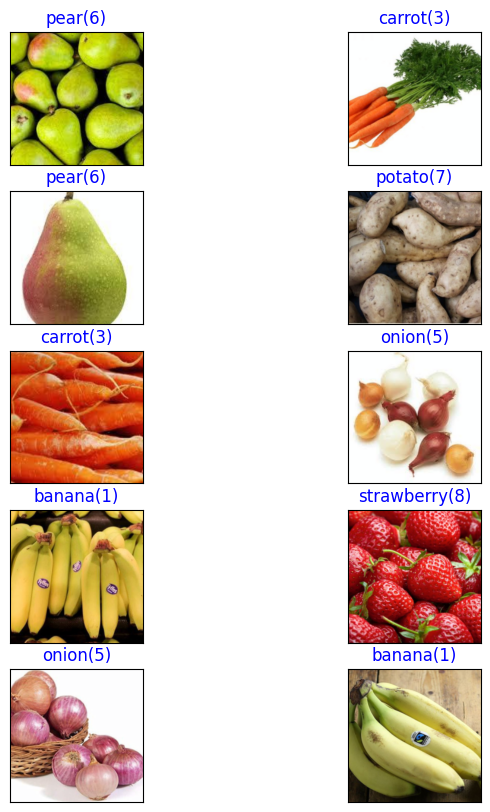

In [6]:
# Visualization of images

# get some random training images
# a quick explanation of iter() and next():
# https://stackoverflow.com/questions/62549990/what-does-next-and-iter-do-in-pytorchs-dataloader

def plot_images_from_dataset(images, labels):
    batch_size = images.shape[0]
    fig = plt.figure(figsize=(8, 10))
    for idx in np.arange(int(batch_size)):
        ax = fig.add_subplot(5, int(batch_size/5), idx+1, xticks=[], yticks=[])
        img = np.squeeze(images[idx])
        # revert normalisation
        img = img * np.expand_dims(np.array([0.229, 0.224, 0.225]), (1, 2)) + np.expand_dims(np.array([0.485, 0.456, 0.406]), (1, 2))
        img = np.clip(img, 0, 1)
        plt.imshow(np.transpose(img, (1,2,0)))
        ax.set_title("{}({})".format(classes[labels[idx]],str(labels[idx].item())),
                    color=("blue"))

dataiter = iter(train_loader) #iter() returns an iterator
images, labels = next(dataiter) # call next() on the iterator to get the first iteration

plot_images_from_dataset(images, labels)

/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


how many images in the train set:  400
images per class in dataloader:  {'apple': 40, 'banana': 40, 'bean': 40, 'carrot': 40, 'grape': 40, 'onion': 40, 'pear': 40, 'potato': 40, 'strawberry': 40, 'tomato': 40}


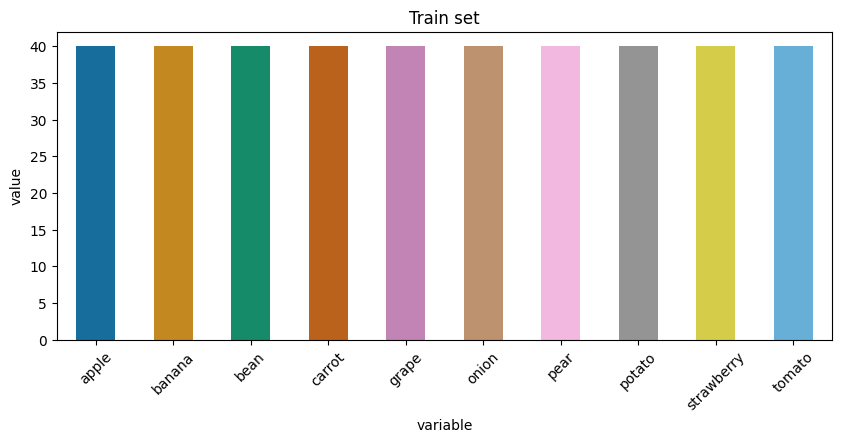

In [7]:
# class distribution
import seaborn as sns
from collections import Counter

print("how many images in the train set: ", len(train_set.targets))

# later in this exercise you will explore the ways to rebalance the data in the dataloader
# TODO modify code form Lab2 to look at the distributions of the images in the dataloader
def plot_class_distribution_for_dataloader(dataloader):
# count how many images are outputted by dataloader per class
    count_dict = {}
    for k,v in Counter(dataloader.dataset.targets).items():
        count_dict[classes[k]] = v
    # YOUR CODE HERE
    # raise NotImplementedError()
    print("images per class in dataloader: ", count_dict)
    plt.figure(figsize=(10, 4))
    #plot the class ditribution
    sns.barplot(data=pd.DataFrame.from_dict([count_dict])[list(classes)].melt(),
                  x="variable", y="value", hue="variable", palette="colorblind", width = 0.5,  dodge=False)

    plt.title("Train set")
    plt.xticks(rotation=45)
    plt.legend().set_visible(False)
    plt.show()

plot_class_distribution_for_dataloader(train_loader)
## the training set is perfectly balanced: same number of image for all classes

##### Metrics

##### 3.2 Introducing simple metrics, such as accuracy and F1-score.


In [8]:
from sklearn.metrics import f1_score, accuracy_score
def f1(preds, target):
    return f1_score(target, preds, average='macro')

def acc(preds, target):
    return accuracy_score(target, preds)

In [9]:
preds = torch.randint(0, 10, (20, ))
target = torch.randint(0, 10, (20, ))
print(preds, target)
print('accuracy', acc(preds, target))
print('f1-macro score', f1(preds, target))

print('\n')

preds = torch.tensor([0, 9, 7, 3, 8, 1, 6, 2, 7, 9])
target = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
print(preds, target)
print('accuracy', acc(preds, target))
print('f1-macro score', f1(preds, target))
assert acc(preds, target) == 0.4
assert (f1(preds, target)<= 0.366666666 + 1e-5) and (f1(preds, target) >= 0.366666666 - 1e-5)

print('\n')

preds = torch.tensor([0, 9, 7,])
target = torch.tensor([0, 1, 2])
print(preds, target)
print('accuracy', acc(preds, target))
print('f1-macro score', f1(preds, target))

tensor([3, 2, 5, 0, 3, 4, 4, 1, 5, 7, 3, 7, 8, 3, 9, 8, 6, 7, 3, 1]) tensor([2, 9, 3, 0, 1, 1, 3, 0, 9, 2, 1, 7, 2, 2, 0, 0, 3, 0, 5, 3])
accuracy 0.1
f1-macro score 0.08333333333333333


tensor([0, 9, 7, 3, 8, 1, 6, 2, 7, 9]) tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
accuracy 0.4
f1-macro score 0.36666666666666664


tensor([0, 9, 7]) tensor([0, 1, 2])
accuracy 0.3333333333333333
f1-macro score 0.2


#### Model

##### 3.3 Loading pretrained network

You will fine-tune AlexNet: have a look at these 2 papers:

- [Original paper reaching a 15% top-5 error rate](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks)
- [How to parallelize the training across multiple GPUs](https://arxiv.org/abs/1404.5997)

The architecture of AlexNet is very similar to the LeNet5 convolutional network, except that it has more parameters and takes as input images of size `224x224`.

<div style="max-width:80%; margin:auto; padding:10px;">



</div>

Load AlexNet from the pytorch `models` module. By default, the model will be downloaded in `${TORCH_HOME}`. If not set, the default location is `~/.cache/torch`. You can find some information on how to load an existing architecture [here](https://pytorch.org/vision/stable/models.html), in particular, pay attention to the `weights` argument, and not using the deprecated `pretrained` one.

In [10]:
import torchvision.models as models
# Load a pretrained AlexNet (use flag 'weights' properly)
#
# model = ...
# (1 line of code)
# YOUR CODE HERE
# raise NotImplementedError()
model = models.alexnet(weights=True)

/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
assert isinstance(model, models.AlexNet)

Print the model by running the following piece of code. In PyTorch, AlexNet consists of 2 parts:

1. the feature extractor, made of convolutional layers, max pooling, and non linearities,
1. the classifier, made of fully connected layers (Linear) and non linearities.

In [12]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

The pre-trained version you have loaded was trained on ImageNet (one million images) to classify 1000 classes. Your task here consists in classifying 10 classes.

To fine-tune the network, we will freeze the `features` part, because:

1. the features are already good, since AlexNet achieves good performance on ImageNet, and we are dealing with color images similar to the ones of ImageNet.
1. this will speed up the fine-tuning (the back propagation will be faster)

We will use less filters in the `classifier` part, because:

1. we are only working with 10 classes, so no need to overkill it,
1. this will also speed up the training phase.

In the next block of code, you will:

1. Freeze the feature layers (you can find an example [here](https://pytorch.org/docs/stable/notes/autograd.html#setting-requires-grad)),
1. Create new linear layers in the classifier part with 128 hidden units (`nn.Linear(..., ...)`).

In [13]:
# Start by freezing the layers of the `features` part
# of the network
#
# For loop over "features" parameters.
# (~2 lines of code)
# YOUR CODE HERE
# raise NotImplementedError()
for param in model.features.parameters():
    param.requires_grad = False

# We modify the last layers for retraining
# (for them, requires_grad will be true).
# Only these layers will be updated during
# back propagation
#
# model.classifier[?] = nn.Linear(...)
# (3 lines of code)
# YOUR CODE HERE
# raise NotImplementedError()
model.classifier[1] = nn.Linear(9216, 128)
model.classifier[4] = nn.Linear(128, 128)
model.classifier[6] = nn.Linear(128, 10)

print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=128, bias=True)
  

In [14]:
print(model.classifier[1].weight.size())

torch.Size([128, 9216])


In [15]:
assert model.classifier[1].weight.size() == torch.Size([128, 9216]), "Should be 128 x 9216"
assert model.classifier[4].weight.size() == torch.Size([128, 128]), "Should be 128 x 128"
assert model.classifier[6].weight.size() == torch.Size([10, 128]), "Should be 10 x 128"
assert not model.features[0].weight.requires_grad, "Have you frozen the layers of ALL the feature part?"
assert not model.features[0].bias.requires_grad, "Have you frozen the layers of ALL the feature part?"
assert not model.features[10].weight.requires_grad, "Have you frozen the layers of ALL the feature part?"
assert not model.features[10].bias.requires_grad, "Have you frozen the layers of ALL the feature part?"

In [23]:
class FruitNet(nn.Module):
    def __init__(self, weights=None):
        super().__init__()
        # YOUR CODE HERE
        # raise NotImplementedError()
        self.model = models.alexnet(weights=weights)

        # Change the last layers
        #
        # model.classifier[?] = nn.Linear(...)
        # (3 lines of code)
        # YOUR CODE HERE
        # raise NotImplementedError()
        self.model.classifier[1] = nn.Linear(9216, 128)
        self.model.classifier[4] = nn.Linear(128, 128)
        self.model.classifier[6] = nn.Linear(128, 10)

    def freeze_feature_layers(self):
        # Freeze the feature extraction part
        #
        # For loop over "self.features" parameters.
        # (~2 lines of code)
        # YOUR CODE HERE
        # raise NotImplementedError()
        for param in self.model.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.model(x)

Let's check that the wrapper does what it is needed:

In [24]:
# Load a non trained model
assert_model = FruitNet()
assert assert_model.model.classifier[1].weight.size() == torch.Size([128, 9216]), "Should be 128 x 9216"
assert assert_model.model.classifier[4].weight.size() == torch.Size([128, 128]), "Should be 128 x 128"
assert assert_model.model.classifier[6].weight.size() == torch.Size([10, 128]), "Should be 10 x 128"
assert assert_model.model.features[0].weight.requires_grad, "When creating the model, the layers should not be frozen"
assert_model.freeze_feature_layers()
assert not assert_model.model.features[0].weight.requires_grad, "After calling `freeze_feature_layers`, the layers should be frozen"
assert assert_model.model.classifier[6].weight.requires_grad, "The classifier should not be frozen as we will train it"
assert_model1 = FruitNet(weights=None)
assert_model2 = FruitNet(weights="DEFAULT")
assert not torch.equal(assert_model1.model.features[0].weight, assert_model2.model.features[0].weight), "Did you use the input `weights` argument, and not hardcoding weights when loading alexnet? Or did you use the `pretrained` flag?"

#### Gradient flow

##### 3.4 Learning about the gradient flow implementation in pytorch. Learning about components of a training(loss.backwards(), optimizer.zero_grad(), optimizer.step()).


In [25]:
#first, let's take a look at how gradients work in torch
#we will implement a linear layer: ax + b

import torch
import torch.nn as nn

x = torch.rand((8, 10))
y = torch.randint(0, 2, (8, 1)).to(torch.float32)

x, y

(tensor([[0.1996, 0.0798, 0.7518, 0.4311, 0.0774, 0.4477, 0.8730, 0.8874, 0.1641,
          0.2132],
         [0.8346, 0.2812, 0.4628, 0.0533, 0.0574, 0.4216, 0.6233, 0.1641, 0.3105,
          0.7253],
         [0.2253, 0.5144, 0.8055, 0.8090, 0.1140, 0.5820, 0.9185, 0.2721, 0.0855,
          0.1913],
         [0.6006, 0.4687, 0.2758, 0.0444, 0.1147, 0.0271, 0.2020, 0.6188, 0.9342,
          0.8830],
         [0.1273, 0.1239, 0.4620, 0.8326, 0.3717, 0.4046, 0.0994, 0.4756, 0.1083,
          0.5371],
         [0.9288, 0.5526, 0.1930, 0.0587, 0.7945, 0.5586, 0.3229, 0.8244, 0.8548,
          0.3631],
         [0.0832, 0.8413, 0.3681, 0.1686, 0.4057, 0.0181, 0.1839, 0.1275, 0.2702,
          0.0337],
         [0.9870, 0.8567, 0.9097, 0.8063, 0.0962, 0.0855, 0.4535, 0.5488, 0.6599,
          0.5020]]),
 tensor([[1.],
         [1.],
         [0.],
         [0.],
         [1.],
         [1.],
         [0.],
         [1.]]))

In [27]:
model = nn.Linear(10, 1, bias=True)

print(model)

print('parameters:', model.weight, model.bias)
print('\n')
print('gradients:',model.weight.grad, model.bias.grad)

Linear(in_features=10, out_features=1, bias=True)
parameters: Parameter containing:
tensor([[ 0.0427,  0.0450,  0.1629, -0.0843,  0.3086, -0.0751, -0.0588,  0.0625,
          0.1724, -0.2387]], requires_grad=True) Parameter containing:
tensor([-0.2325], requires_grad=True)


gradients: None None


In [28]:
#parameter requires_grad identifies if the flow of gradients will go through the variable
x.requires_grad, y.requires_grad, model.weight.requires_grad, model.bias.requires_grad

(False, False, True, True)

In [29]:
model.weight.grad, model.bias.grad #no steps were made so far, so no gradients

(None, None)

In [31]:
out = model(x) #forward pass
out, out.grad
# Warning: out is not a leaf tensor - which means it keeps track of operations that were made to receive a variable

/tmp/ipykernel_59951/3175012831.py:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  out, out.grad


(tensor([[-0.1626],
         [-0.2734],
         [-0.2133],
         [-0.1342],
         [-0.2178],
         [ 0.1549],
         [ 0.0141],
         [-0.0469]], grad_fn=<AddmmBackward0>),
 None)

In [34]:
#optimizer defines the rule for how the parameters will be updated
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer.zero_grad()

#we have not computed the gradients thought, so they are still None
model.weight.grad, model.bias.grad

(None, None)

In [35]:
# You can see that output variable out has a parameter grad_fn=<AddmmBackward0>
# The backward pass has to be constructed for gradients to appear

#create a loss instance
bce = nn.BCEWithLogitsLoss()

#compute the loss value
loss = bce(out, y)
loss

tensor(0.7101, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [36]:
#compute gradient
loss.backward()

In [37]:
print('parameters:', model.weight, model.bias)
print('\n')
print('gradients:',model.weight.grad, model.bias.grad)
#we see that model weights are not updated yet, but the gradients for each parameter are computed in the .grad variable

parameters: Parameter containing:
tensor([[ 0.0427,  0.0450,  0.1629, -0.0843,  0.3086, -0.0751, -0.0588,  0.0625,
          0.1724, -0.2387]], requires_grad=True) Parameter containing:
tensor([-0.2325], requires_grad=True)


gradients: tensor([[-0.1454, -0.0116, -0.1007, -0.0872, -0.0484, -0.0907, -0.0831, -0.1279,
         -0.0559, -0.0918]]) tensor([-0.1524])


In [38]:
#we update the model parameters, but note that the previously computed gradients in .grad are still inplace

optimizer.step()

print('parameters:', model.weight, model.bias)
print('\n')
print('gradients:',model.weight.grad, model.bias.grad)

#if you do the forwards and backward steps again, the new gradients are going to sum with the existing in .grad, which is NOT what we need

parameters: Parameter containing:
tensor([[ 0.0437,  0.0460,  0.1639, -0.0833,  0.3096, -0.0741, -0.0578,  0.0635,
          0.1734, -0.2377]], requires_grad=True) Parameter containing:
tensor([-0.2315], requires_grad=True)


gradients: tensor([[-0.1454, -0.0116, -0.1007, -0.0872, -0.0484, -0.0907, -0.0831, -0.1279,
         -0.0559, -0.0918]]) tensor([-0.1524])


In [39]:
#that's why we have to empty the gradients in .grad after we updated the weights
# oterwise we will keep collecting the gradients from the previous steps and updating the values with them would lead to going into an incorrectt directio
optimizer.zero_grad()

print('parameters:', model.weight, model.bias)
print('\n')
print('gradients:',model.weight.grad, model.bias.grad)


parameters: Parameter containing:
tensor([[ 0.0437,  0.0460,  0.1639, -0.0833,  0.3096, -0.0741, -0.0578,  0.0635,
          0.1734, -0.2377]], requires_grad=True) Parameter containing:
tensor([-0.2315], requires_grad=True)


gradients: None None


#### Train cycle

##### 3.5 Implementing the training and evaluation functions, logging and plotting the metrics.


In [40]:
##
from tqdm import tqdm #to see the progress of training
from IPython.display import clear_output



def train_epoch(model, optimizer, criterion, metrics, train_loader, device):
    '''
    device = torch.device('cuda') or torch.device('cpu') if no GPU available
    '''

    #we activate the training state for the model
    model.train()
    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    for batch_num, (x_batch, y_batch) in tqdm(enumerate(train_loader)):
        data = x_batch.to(device)
        target = y_batch.to(device)

        #clean previously computed gradients
        # add 1 line of code
        # YOUR CODE HERE
        # raise NotImplementedError()
        optimizer.zero_grad()

        # forward
        # add 1 line of code
        # outputs = ...
        # YOUR CODE HERE
        # raise NotImplementedError()
        outputs = model(data)

        #compute predictions
        # store predictions in variable preds
        # no gradients should be propagated at this step
        # YOUR CODE HERE
        # raise NotImplementedError()
        preds = torch.argmax(outputs, dim=1)

        #compute loss
        # loss = ...
        # add 1 line of code
        # YOUR CODE HERE
        # raise NotImplementedError()
        loss = criterion(outputs, target)

        #do backward and oprimizer steps
        # add two lines
        # YOUR CODE HERE
        # raise NotImplementedError()
        loss.backward()
        optimizer.step()

        # compute metrics
        # no gradients should be propagated at this step
        with torch.no_grad():
            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](preds, target)


        # log loss statistics
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)

    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(train_loader)

    clear_output() #clean the prints from previous epochs
    print('train Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss,  epoch_metrics

In [41]:
def evaluate(model, criterion, metrics, test_loader, device):

    #we activate the evaluation state for the model
    model.eval()

    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    for batch_num, (x_batch, y_batch) in enumerate(test_loader):
        with torch.no_grad(): # we don't compute gradients here
            data = x_batch.to(device)
            target = y_batch.to(device)

            # forward
            # add 1 line of code
            # outputs = ...
            # YOUR CODE HERE
            # raise NotImplementedError()
            outputs = model(data)

            #compute loss
            # loss = ...
            # add 1 line of code
            # YOUR CODE HERE
            # raise NotImplementedError()
            loss = criterion(outputs, target)

            #compute predictions
            # store predictions in variable preds
            # add 1 line of code
            # YOUR CODE HERE
            # raise NotImplementedError()
            preds = torch.argmax(outputs, dim=1)

            # compute metrics
            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](preds, target)

            # log loss statistics
            epoch_loss += loss.item()

    epoch_loss /= len(test_loader)

    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(test_loader)

    print('eval Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss,  epoch_metrics

In [42]:
def plot_training(train_loss, test_loss, metrics_names, train_metrics_logs, test_metrics_logs):
    fig, ax = plt.subplots(1, len(metrics_names) + 1, figsize=((len(metrics_names) + 1) * 5, 5))

    ax[0].plot(train_loss, c='blue', label='train')
    ax[0].plot(test_loss, c='orange', label='test')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend()

    for i in range(len(metrics_names)):
        ax[i + 1].plot(train_metrics_logs[i], c='blue', label='train')
        ax[i + 1].plot(test_metrics_logs[i], c='orange', label='test')
        ax[i + 1].set_title(metrics_names[i])
        ax[i + 1].set_xlabel('epoch')
        ax[i + 1].legend()

    plt.show()



In [43]:
#actually you have to use validation for each step of training, but now we will focus only on the toy example and will track the perfromance on test
def update_metrics_log(metrics_names, metrics_log, new_metrics_dict):
    for i in range(len(metrics_names)):
        curr_metric_name = metrics_names[i]
        metrics_log[i].append(new_metrics_dict[curr_metric_name])
    return metrics_log


def train_cycle(model, optimizer, criterion, metrics, train_loader, test_loader, n_epochs, device):
    train_loss_log,  test_loss_log = [], []
    metrics_names = list(metrics.keys())
    train_metrics_log = [[] for i in range(len(metrics))]
    test_metrics_log = [[] for i in range(len(metrics))]


    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_metrics = train_epoch(model, optimizer, criterion, metrics, train_loader, device)

        test_loss, test_metrics = evaluate(model, criterion, metrics, test_loader, device)

        train_loss_log.append(train_loss)
        train_metrics_log = update_metrics_log(metrics_names, train_metrics_log, train_metrics)

        test_loss_log.append(test_loss)
        test_metrics_log = update_metrics_log(metrics_names, test_metrics_log, test_metrics)

        plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)
    return train_metrics_log, test_metrics_log


##### 3.6 Training a simple network

It is now time to fine-tune the network: basically, the first layers will be frozen and will not be updated in the backward pass, while the last three linear layers that you have created will be optimized.The first layers which, as we will see later in the course, correspond to image features, which have been trained on  1 million images of ImageNet, so the features are meaningful for image classification and don't need to be updated. We keep them as they are. You will fine-tune the network with:
the cross-entropy loss, and the stochastic gradient descend

train Loss: 0.3304,  ACC: 0.8900, F1-weighted: 0.8391
eval Loss: 0.3146,  ACC: 0.8800, F1-weighted: 0.5671


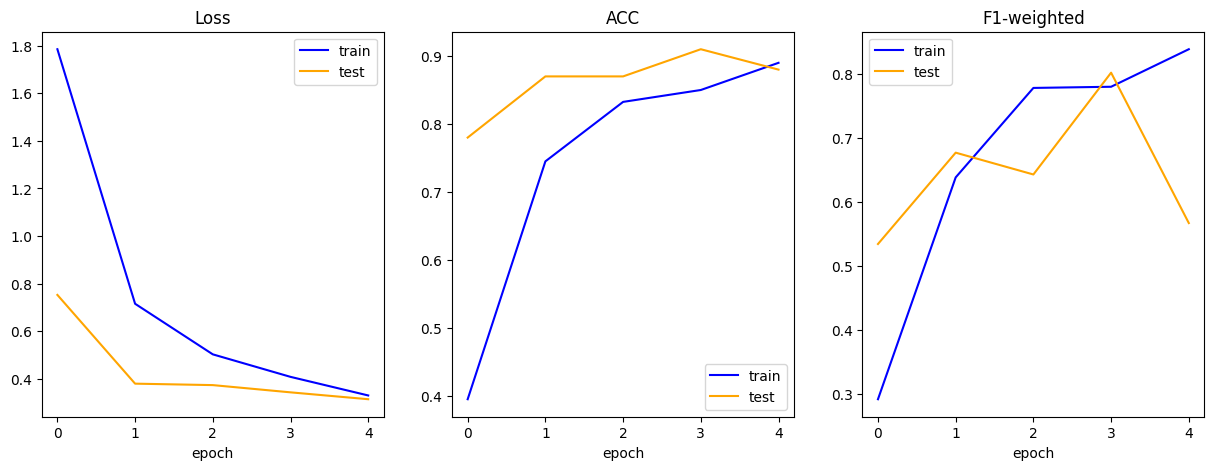

In [44]:
torch.manual_seed(42)

model = FruitNet(weights="IMAGENET1K_V1")
model.freeze_feature_layers()

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

N_EPOCHS = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
# criterion.to(device)

train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_loader, valid_loader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model.pth')

In [ ]:
assert test_metrics_log[0][-1] >= 0.84